In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [3]:
def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)

In [4]:
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [5]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels


In [6]:
names, data, labels = read_data('../data/cifar-10-batches-py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


In [7]:
def show_some_examples(names, data, labels):
    plt.figure()
    rows, cols = 4, 4
    random_idxs = random.sample(range(len(data)), rows * cols)
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        j = random_idxs[i]
        plt.title(names[labels[j]])
        img = np.reshape(data[j, :], (24, 24))
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('../data/cifar_examples.png')


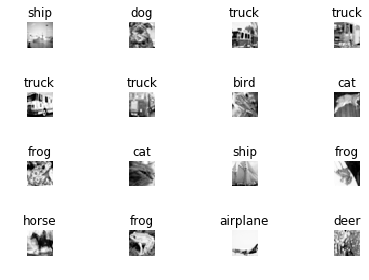

In [8]:
show_some_examples(names, data,  labels)

In [9]:
W = tf.Variable(tf.random_normal([5, 5, 1, 32]))
def show_weights(W, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(W)[3]):
        img = W[:, :, 0, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
        
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

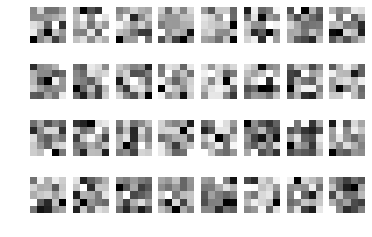

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    W_val = sess.run(W)
    show_weights(W_val, '../data/step0_weights.png')

In [11]:
def show_conv_results(data, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(data)[3]):
        img = data[0, :, :, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

(1, 24, 24, 32)
(1, 24, 24, 32)
(1, 12, 12, 32)


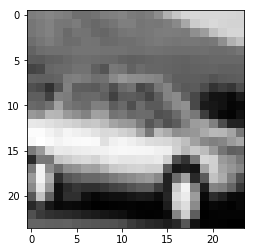

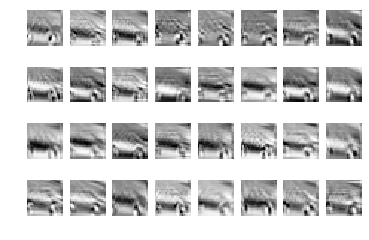

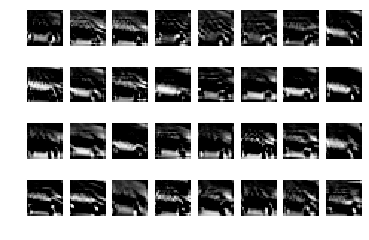

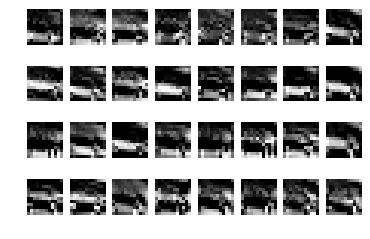

In [12]:
raw_data = data[4, :]
raw_img = np.reshape(raw_data, (24, 24))
plt.figure()
plt.imshow(raw_img, cmap='Greys_r')
plt.savefig('../data/input_image.png')
x = tf.reshape(raw_data, shape=[-1, 24, 24, 1])
b = tf.Variable(tf.random_normal([32]))
conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv_val = sess.run(conv)
    show_conv_results(conv_val, '../data/step1_convs.png')
    print(np.shape(conv_val))
    conv_out_val = sess.run(conv_out)
    show_conv_results(conv_out_val, '../data/step2_conv_outs.png')
    print(np.shape(conv_out_val))
    
    k=2
    maxpool = tf.nn.max_pool(conv_out,
                               ksize=[1, k, k, 1],
                               strides=[1, k, k, 1],
                               padding='SAME')
    maxpool_val = sess.run(maxpool)
    show_conv_results(maxpool_val, '../data/step3_maxpool.png')
    print(np.shape(maxpool_val))